In [1]:
import _base_path
import torch
import pickle
import numpy as np
import pandas as pd

import matplotlib
if 'init_done' in globals():
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })
import matplotlib.pyplot as plt

from resources.evaluator import EvaluatorConformalSimple, EvaluatorMaxK
from resources.data_io import load_mappings, load_data

from TrainerClassic import TrainerClassic
from TrainerTransformer import TrainerTransformer

init_done = True

Setting base bath to "c:\Users\Korbi\Desktop\CICLe"


In [2]:
DATA       = 'incidents'
TEXTS      = 'title'
LABEL      = 'hazard-category'
MIN_K      = 1

TRAD_MODEL = 'tfidf-lr'
DEEP_MODEL = 'roberta-base'

mappings = load_mappings(f"../data/{DATA}/splits/", LABEL)

K          = list(np.arange(0, len(mappings)) + 1)
ALPHAS     = list(np.power(2, np.arange(0, 6, .2)) / 100.)

In [3]:
mappings

array(['allergens', 'biological', 'chemical',
       'food additives and flavourings', 'food contact materials',
       'foreign bodies', 'fraud', 'migration', 'organoleptic aspects',
       'other hazard', 'packaging defect'], dtype=object)

# Predict sets:

## Option 1: Using Model

In [4]:
def predict(load_base_classifier):
    ps_max_k = [pd.DataFrame() for _ in range(5)]
    ps_conf  = [pd.DataFrame() for _ in range(5)]
 
    for i in range(5):
        # load evaluators
        evaluator_base = load_base_classifier(i)
        evaluator_maxk = EvaluatorMaxK(evaluator_base)
        evaluator_conf = EvaluatorConformalSimple(evaluator_base)

        # load data:
        _, data_calib, data_test = load_data(
            f"../data/{DATA}/splits/",
            TEXTS,
            LABEL,
            i,
            evaluator_base.tokenizer,
            add_texts=True
        )

        # predict class probabilities:
        probs = evaluator_base.predict(data_test)

        ps_max_k[i]['texts']  = evaluator_base.last_texts
        ps_max_k[i]['labels'] = list(probs['labels'])
        
        ps_conf[i]['texts']  = evaluator_base.last_texts
        ps_conf[i]['labels'] = list(probs['labels'])

        # calibrate conformal prediction:
        evaluator_conf.calibrate(data_calib)

        # predict sets:
        for alpha in ALPHAS:
            ps_conf[i][f'{alpha:.2f}'] = evaluator_conf.predict(alpha, y_pred=probs['probabilities'], min_k=MIN_K)['predictions']

        # predict max-k sets:
        for k in K:
            ps_max_k[i][f'{k:d}'] = evaluator_maxk.predict(k, y_pred=probs['probabilities'])['predictions']

    return ps_max_k, ps_conf

In [5]:
ps_classic_max_k, ps_classic_conf = predict(
    lambda i: TrainerClassic.load(
        dir=f'../models/{TRAD_MODEL}/{TRAD_MODEL}-{LABEL}-{i:d}/',
        normalize_fcn='sum'
    )
)

C:\Users\Korbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


C:\Users\Korbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


C:\Users\Korbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


C:\Users\Korbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


C:\Users\Korbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
ps_deep_max_k, ps_deep_conf = predict(
    lambda i: (
        TrainerTransformer.load(
            dir=f'../models/{DEEP_MODEL}/{DEEP_MODEL}-{LABEL}-{i:d}/f1/',
            num_labels=len(mappings),
            batch_size=16,
            normalize_fcn='sum',
            loss_fcn=torch.nn.CrossEntropyLoss(
                #weight=None,
                reduction='mean'
            )
        )
    )
)

OSError: Can't load the configuration of '../models/roberta-base/roberta-base-hazard-category-0/f1/'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure '../models/roberta-base/roberta-base-hazard-category-0/f1/' is the correct path to a directory containing a config.json file

## Option 2: Using Saved Predcitions

In [4]:
def predict(model_name:str):
    ps_max_k = [pd.DataFrame() for _ in range(5)]
    ps_conf  = [pd.DataFrame() for _ in range(5)]
 
    for i in range(5):
        # load evaluators
        evaluator_maxk = EvaluatorMaxK(normalize_fcn='sum')
        evaluator_conf = EvaluatorConformalSimple(normalize_fcn='sum')
        
        with open(f'../results/{model_name}/{model_name}-{LABEL}-calib-{i:d}.pickle', 'rb') as f:
                predictions_calib = pickle.load(f)

        # calibrate conformal prediction:
        evaluator_conf.calibrate(
            y_pred=predictions_calib['probabilities'],
            y_true=predictions_calib['labels']
        )

        with open(f'../results/{model_name}/{model_name}-{LABEL}-{i:d}.pickle', 'rb') as f:
                predictions_test = pickle.load(f)

        ps_max_k[i]['labels'] = list(predictions_test['labels'])
        ps_conf[i]['labels'] = list(predictions_test['labels'])

        # predict sets:
        for alpha in ALPHAS:
            ps_conf[i][f'{alpha:.2f}'] = evaluator_conf.predict(alpha, y_pred=predictions_test['probabilities'], min_k=MIN_K)['predictions']

        # predict max-k sets:
        for k in K:
            ps_max_k[i][f'{k:d}'] = evaluator_maxk.predict(k, y_pred=predictions_test['probabilities'])['predictions']

    return ps_max_k, ps_conf

In [5]:
ps_classic_max_k, ps_classic_conf = predict(TRAD_MODEL)

In [6]:
ps_deep_max_k, ps_deep_conf = predict(DEEP_MODEL)

# Best traditional classifier:

In [7]:
def evaluate(ps, keys):
    sl, sa = {}, {}

    for key in keys:
        sl[key] = [len(y_pred) for df in ps for y_pred in df[key].values]
        #sa[key] = [np.mean([np.argmax(y_true) in y_pred['i'] for y_true, y_pred in df[['labels', key]].values]) for df in ps]
        sa[key] = [np.mean([y_true in y_pred['i'] for y_true, y_pred in df[['labels', key]].values]) for df in ps]

    return sl, sa

## max-$k$ prediction:

In [8]:
# evaluate set length and accuracy:
sl_classic_max_k, sa_classic_max_k = evaluate(ps_classic_max_k, [f'{k:d}' for k in K])

In [9]:
# print best:
k = '5'
print(f'Set length: ${np.mean(sl_classic_max_k[k]):.2f} \\pm {np.std(sl_classic_max_k[k]):.2f}$')
print(f'    -> max: ${np.max(sl_classic_max_k[k]):.2f}$')
print(f'    -> min: ${np.min(sl_classic_max_k[k]):.2f}$')
print()
print(f'Set accuracy: ${np.mean(sa_classic_max_k[k]):.2f} \\pm {np.std(sa_classic_max_k[k]):.2f}$')
print(f'      -> max: ${np.max(sa_classic_max_k[k]):.2f}$')
print(f'      -> min: ${np.min(sa_classic_max_k[k]):.2f}$')

Set length: $5.00 \pm 0.00$
    -> max: $5.00$
    -> min: $5.00$

Set accuracy: $0.97 \pm 0.00$
      -> max: $0.98$
      -> min: $0.96$


## Conformal prediction:

In [10]:
# evaluate set length and accuracy:
sl_classic_conf, sa_classic_conf = evaluate(ps_classic_conf, [f'{alpha:.2f}' for alpha in ALPHAS])

In [11]:
# print best:
alpha = '0.01'
print(f'Set length: ${np.mean(sl_classic_conf[alpha]):.2f} \\pm {np.std(sl_classic_conf[alpha]):.2f}$')
print(f'    -> max: ${np.max(sl_classic_conf[alpha]):.2f}$')
print(f'    -> min: ${np.min(sl_classic_conf[alpha]):.2f}$')
print()
print(f'Set accuracy: ${np.mean(sa_classic_conf[alpha]):.2f} \\pm {np.std(sa_classic_conf[alpha]):.2f}$')
print(f'      -> max: ${np.max(sa_classic_conf[alpha]):.2f}$')
print(f'      -> min: ${np.min(sa_classic_conf[alpha]):.2f}$')

Set length: $5.42 \pm 2.33$
    -> max: $10.00$
    -> min: $1.00$

Set accuracy: $0.99 \pm 0.00$
      -> max: $1.00$
      -> min: $0.99$


# Best transformer:

## max-$k$ prediction:

In [12]:
# evaluate set length and accuracy:
sl_deep_max_k, sa_deep_max_k = evaluate(ps_deep_max_k, [f'{k:d}' for k in K])

In [13]:
# print best:
k = '5'
print(f'Set length: ${np.mean(sl_deep_max_k[k]):.2f} \\pm {np.std(sl_deep_max_k[k]):.2f}$')
print(f'    -> max: ${np.max(sl_deep_max_k[k]):.2f}$')
print(f'    -> min: ${np.min(sl_deep_max_k[k]):.2f}$')
print()
print(f'Set accuracy: ${np.mean(sa_deep_max_k[k]):.2f} \\pm {np.std(sa_deep_max_k[k]):.2f}$')
print(f'      -> max: ${np.max(sa_deep_max_k[k]):.2f}$')
print(f'      -> min: ${np.min(sa_deep_max_k[k]):.2f}$')

Set length: $5.00 \pm 0.00$
    -> max: $5.00$
    -> min: $5.00$

Set accuracy: $0.95 \pm 0.02$
      -> max: $0.97$
      -> min: $0.93$


## Conformal prediction:

In [14]:
# evaluate set length and accuracy:
sl_deep_conf, sa_deep_conf = evaluate(ps_deep_conf, [f'{alpha:.2f}' for alpha in ALPHAS])

In [15]:
# print best:
alpha = '0.01'
print(f'Set length: ${np.mean(sl_deep_conf[alpha]):.2f} \\pm {np.std(sl_deep_conf[alpha]):.2f}$')
print(f'    -> max: ${np.max(sl_deep_conf[alpha]):.2f}$')
print(f'    -> min: ${np.min(sl_deep_conf[alpha]):.2f}$')
print()
print(f'Set accuracy: ${np.mean(sa_deep_conf[alpha]):.2f} \\pm {np.std(sa_deep_conf[alpha]):.2f}$')
print(f'      -> max: ${np.max(sa_deep_conf[alpha]):.2f}$')
print(f'      -> min: ${np.min(sa_deep_conf[alpha]):.2f}$')

Set length: $6.34 \pm 3.11$
    -> max: $11.00$
    -> min: $1.00$

Set accuracy: $0.99 \pm 0.00$
      -> max: $0.99$
      -> min: $0.98$


# Plots:

In [16]:
def boxplot(**kwargs):
    data   = []
    labels = []
    for param in kwargs:
        for value in kwargs[param]:
            data.append(kwargs[param][value])
            labels.append(f'${param}={value}$')

    plt.boxplot(np.transpose(np.array(data)), labels=labels)

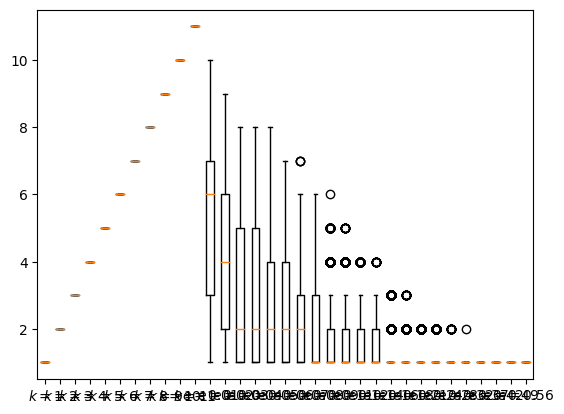

In [17]:
boxplot(k=sl_classic_max_k, e=sl_classic_conf)

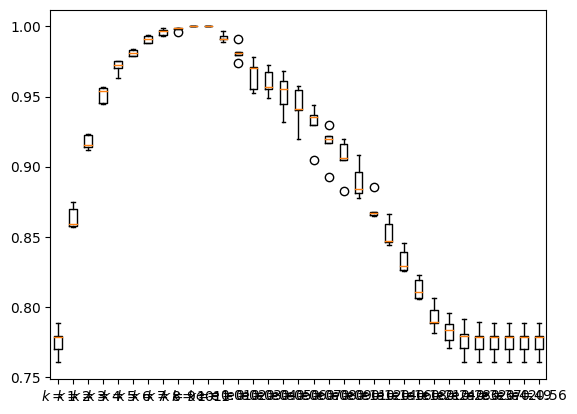

In [18]:
boxplot(k=sa_classic_max_k, e=sa_classic_conf)

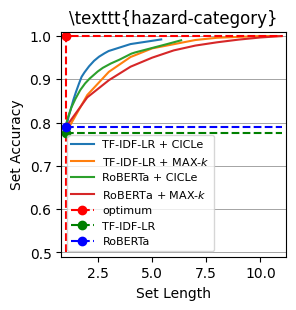

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

clf_classic = 'TF-IDF-LR'
clf_deep = 'RoBERTa'
left = (LABEL == 'hazard-category')

# plot curve for conformal with best traditional cf:
data_x_classic_conf = []
data_y_classic_conf = []
try:
    for alpha in sl_classic_conf:
        data_x_classic_conf.append(np.mean(sl_classic_conf[alpha]))
        data_y_classic_conf.append(np.mean(sa_classic_conf[alpha]))
    ax.plot(data_x_classic_conf, data_y_classic_conf, label=f'{clf_classic} + CICLe')
except NameError: pass

# plot curve for max-k with best traditional cf:
data_x_classic_max_k = []
data_y_classic_max_k = []
try:
    for k in sl_classic_max_k:
        data_x_classic_max_k.append(np.mean(sl_classic_max_k[k]))
        data_y_classic_max_k.append(np.mean(sa_classic_max_k[k]))
    ax.plot(data_x_classic_max_k, data_y_classic_max_k, label=f'{clf_classic} + MAX-$k$')
except NameError: pass

# plot curve for conformal with best transformer cf:
data_x_deep_conf = []
data_y_deep_conf = []
try:
    for alpha in sl_deep_conf:
        data_x_deep_conf.append(np.mean(sl_deep_conf[alpha]))
        data_y_deep_conf.append(np.mean(sa_deep_conf[alpha]))
    ax.plot(data_x_deep_conf, data_y_deep_conf, label=f'{clf_deep} + CICLe')
except NameError: pass

# plot curve for max-k with best transformer cf:
data_x_deep_max_k = []
data_y_deep_max_k = []
try:
    for k in sl_deep_max_k:
        data_x_deep_max_k.append(np.mean(sl_deep_max_k[k]))
        data_y_deep_max_k.append(np.mean(sa_deep_max_k[k]))
    ax.plot(data_x_deep_max_k, data_y_deep_max_k, label=f'{clf_deep} + MAX-$k$')
except NameError: pass

# plot extreme values:
x_max = max([max(data_x_classic_max_k), max(data_x_classic_conf)])
ax.plot([1., 1., x_max], [.5, 1., 1.], 'r--')
ax.plot(1., 1., 'or--', label='optimum')

# plot base performance:
try:
    y_min_classic = np.mean(sa_classic_max_k['1'])
    ax.plot([1., x_max], [y_min_classic, y_min_classic], 'g--')
    ax.plot(1, y_min_classic, 'og--', label=clf_classic)
except NameError: pass

try:
    y_min_deep = np.mean(sa_deep_max_k['1'])
    ax.plot([1., x_max], [y_min_deep, y_min_deep], 'b--')
    ax.plot(1, y_min_deep, 'ob--', label=clf_deep)
except NameError: pass

margin = (x_max-1.) * 0.02
ax.set_xlim(1 - margin, x_max + margin)

margin = 0.5 * 0.02
ax.set_ylim(0.5 - margin, 1 + margin)

for y in [.5, .6, .7, .8 , .9, 1.]:
    ax.axhline(y, linewidth=.5, color='grey', zorder=0)

ax.set_title(f'\\texttt\u007B{LABEL}\u007D')
ax.set_xlabel('Set Length')
if left:
    ax.set_yticks([.5, .6, .7, .8 , .9, 1.])
    ax.set_ylabel('Set Accuracy')
    ax.legend(fontsize=8)

else:
    ax.set_yticks([])
    ax.set_ylabel('')

plt.subplots_adjust(bottom=0.15, left=0.2, right=.95, top=.9)
plt.savefig(f'plots/conformal_performance_{LABEL}.pdf')
plt.show()